In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from IPython.display import Image
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from surprise import SVD, Dataset, Reader
from surprise.model_selection import PredefinedKFold
from collections import defaultdict
from surprise.accuracy import rmse
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline 
sns.set(style="ticks")

/kaggle/input/wine-reviews/winemag-data_first150k.csv
/kaggle/input/wine-reviews/winemag-data-130k-v2.json
/kaggle/input/wine-reviews/winemag-data-130k-v2.csv


In [2]:
data = pd.read_csv('/kaggle/input/wine-reviews/winemag-data-130k-v2.csv', index_col=0)

In [5]:
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [6]:
data.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [7]:
print('Количество критиков\t', len(data.taster_name.unique()))
print('Количество вин\t', len(data.title.unique()))

Количество критиков	 20
Количество вин	 118840


In [8]:
data.describe(include='all',).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,129908,43,US,54504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,129971,119955,"Stalky aromas suggest hay and green herbs, wit...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,92506,37979,Reserve,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,129971.0,NaN,NaN,NaN,88.447138,3.03973,80.0,86.0,88.0,91.0,100.0
price,120975.0,NaN,NaN,NaN,35.363389,41.022218,4.0,17.0,25.0,42.0,3300.0
province,129908,425,California,36247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,108724,1229,Napa Valley,4480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,50511,17,Central Coast,11065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taster_name,103727,19,Roger Voss,25514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taster_twitter_handle,98758,15,@vossroger,25514,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams.update({'font.size':12})

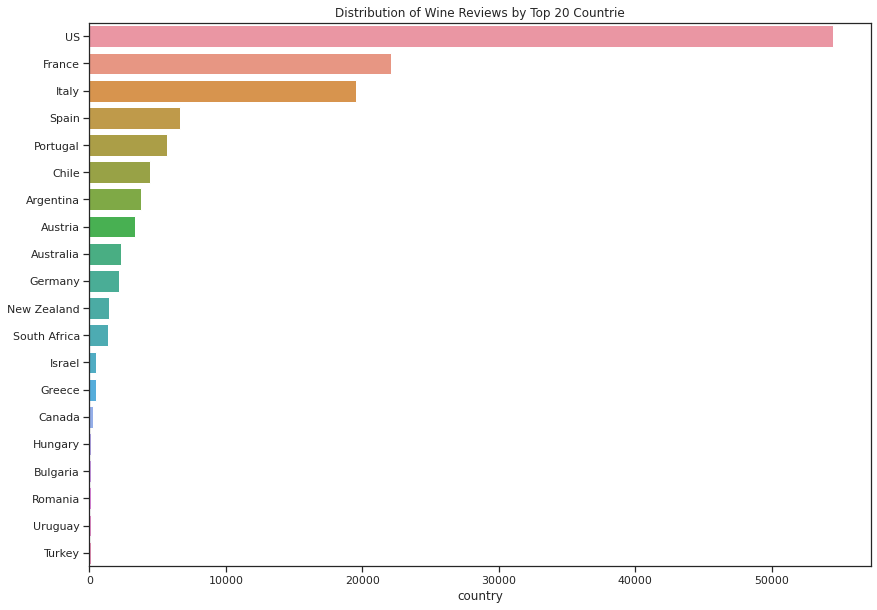

In [10]:
plt.figure(figsize=(14,10))
cnt = data['country'].value_counts().to_frame()[0:20]
#plt.xscale('log')
sns.barplot(x= cnt['country'], y =cnt.index, data=cnt)
plt.title('Distribution of Wine Reviews by Top 20 Countrie');

Больше всего оценок для вин из США

Удалю строки, где не заполнен критик

Так же удалю столбцы

In [11]:
# проверим есть ли пропущенные значения
data.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

In [12]:
data.drop(['taster_twitter_handle', 'region_2', 'designation' ], axis = 1, inplace=True)
data.dropna(subset=['taster_name' ], inplace=True)

In [13]:
# проверим есть ли пропущенные значения
data.isnull().sum()

country           63
description        0
points             0
price           7248
province          63
region_1       20880
taster_name        0
title              0
variety            0
winery             0
dtype: int64

Пропуски в country буду заменять самой часто встречающейся страной, в price - медианой цен в конкретной стране, в region_1 - меткой "Unknown"

In [14]:
data.country.value_counts()

US                        37730
France                    21828
Italy                     11042
Spain                      6581
Portugal                   5686
Chile                      4361
Argentina                  3797
Austria                    3337
Germany                    2134
Australia                  2037
South Africa               1328
New Zealand                1311
Israel                      500
Greece                      466
Canada                      256
Hungary                     145
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Slovenia                     87
Georgia                      86
England                      74
Croatia                      73
Mexico                       65
Moldova                      59
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine                      14
Serbia  

In [15]:
d = data.groupby('country').mean('price')
d.price

country
Argentina                 24.452438
Armenia                   14.500000
Australia                 37.492277
Austria                   30.782157
Bosnia and Herzegovina    12.500000
Brazil                    23.765957
Bulgaria                  14.645390
Canada                    35.636364
Chile                     20.869686
China                     18.000000
Croatia                   25.450704
Cyprus                    16.272727
Czech Republic            24.250000
Egypt                           NaN
England                   51.681159
France                    41.190528
Georgia                   19.321429
Germany                   42.452461
Greece                    22.364425
Hungary                   40.402778
India                     13.333333
Israel                    31.973140
Italy                     41.607450
Lebanon                   30.685714
Luxembourg                23.333333
Macedonia                 15.583333
Mexico                    27.800000
Moldova             

In [16]:
data['region_1'].fillna('Unknown', inplace=True)
data['province'].fillna('Unknown', inplace=True)
data['country'].fillna(data.country.value_counts().index[0], inplace=True)
data['price'].fillna(data['price'].median(), inplace=True)

In [17]:
# проверим есть ли пропущенные значения
data.isnull().sum()

country        0
description    0
points         0
price          0
province       0
region_1       0
taster_name    0
title          0
variety        0
winery         0
dtype: int64

### Векторизация описания

In [18]:
data.title[3]

'St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore)'

In [19]:
import re
def preprocess_sentence(w):
    # отделение слов и знаков пунктуации пробелом
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub('\t\n', '', w)
    w = re.sub(r'http\S+', '', w)
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    

    # удаляем все кроме (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,`']+", " ", w)

    w = w.strip()

    return w

In [20]:
data.description.apply(preprocess_sentence).values

array(["Aromas include tropical fruit , broom , brimstone and dried herb . The palate isn't overly expressive , offering unripened apple , citrus and dried sage alongside brisk acidity .",
       "This is ripe and fruity , a wine that is smooth while still structured . Firm tannins are filled out with juicy red berry fruits and freshened with acidity . It's already drinkable , although it will certainly be better from .",
       'Tart and snappy , the flavors of lime flesh and rind dominate . Some green pineapple pokes through , with crisp acidity underscoring the flavors . The wine was all stainless steel fermented .',
       ...,
       'Well drained gravel soil gives this wine its crisp and dry character . It is ripe and fruity , although the spice is subdued in favor of a more serious structure . This is a wine to age for a couple of years , so drink from .',
       'A dry style of Pinot Gris , this is crisp with some acidity . It also has weight and a solid , powerful core of spic

In [21]:
data.head()

,country,description,points,price,province,region_1,taster_name,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,25.0,Sicily & Sardinia,Etna,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Unknown,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [22]:
tfidfv = TfidfVectorizer()
description_matrix = tfidfv.fit_transform(data.description.apply(preprocess_sentence).values)
title_matrix = tfidfv.fit_transform(data.title.values)
taster_name_matrix = tfidfv.fit_transform(data.taster_name.values)
country_matrix = tfidfv.fit_transform(data.country.values)
province_matrix = tfidfv.fit_transform(data.province.values)

## Фильтрация на основе содержания

In [23]:
class SimpleKNNRecommender:
    
    def __init__(self, X_matrix, X_ids, X_title, X_overview):
        """
        Входные параметры:
        X_matrix - обучающая выборка (матрица объект-признак)
        X_ids - массив идентификаторов объектов
        X_title - массив названий объектов
        X_overview - массив описаний объектов
        """
        #Сохраняем параметры в переменных объекта
        self._X_matrix = X_matrix
        self.df = pd.DataFrame(
            {'id': pd.Series(X_ids, dtype='int'),
            'title': pd.Series(X_title, dtype='str'),
            'overview': pd.Series(X_overview, dtype='str'),
            'dist': pd.Series([], dtype='float')})
            
            
    def recommend_for_single_object(self, K: int, \
                X_matrix_object, cos_flag = True, manh_flag = False):
        """
        Метод формирования рекомендаций для одного объекта.
        Входные параметры:
        K - количество рекомендуемых соседей 
        X_matrix_object - строка матрицы объект-признак, соответствующая объекту
        cos_flag - флаг вычисления косинусного расстояния
        manh_flag - флаг вычисления манхэттэнского расстояния
        Возвращаемое значение: K найденных соседей
        """
        
        scale = 1000000
        # Вычисляем косинусную близость
        if cos_flag:
            dist = cosine_similarity(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=False)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] < scale]
        
        else:
            if manh_flag:
                dist = manhattan_distances(self._X_matrix, X_matrix_object)
            else:
                dist = euclidean_distances(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=True)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] > 0.0]            
        
        # Оставляем К первых рекомендаций
        res = res.head(K)
        return res

In [24]:
# будем искать вина, похожие на 'St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore)' id 3
usRiesling = 3
data.title.values[usRiesling]

'St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore)'

In [25]:
skr1 = SimpleKNNRecommender(description_matrix, data.points.values, data.variety.values, data.description.values)

In [26]:
pd.set_option('max_colwidth', -1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [27]:
# 15 вин, похаожих на рислинг - белое вино
# в порядке убывания схожести на основе косинусного сходства
rec1 = skr1.recommend_for_single_object(15, description_matrix[usRiesling])
rec1

,id,title,overview,dist
62487,87,Mtsvane,"Aromas of orange blossom and lemon pith prime the palate for flavors of pink grapefruit, orange zest, lemon curd and white flowers. This wine is refreshing from start to finish.",334858.139746
49247,86,Chardonnay,Jasmine and fresh-cut pineapple scents lead the way to tropical fruit flavors of guava and mango and a soft finish.,324769.253473
68204,88,Chardonnay,"Slightly astringent, textural tones of citrus rind, apple peel and almond skin are supported by rich notes of pineapple and mango. The medium-weight palate is zingy and refreshing, with an orange-zest flavor and soft toasty character on the close. Drink now.",282095.626662
88367,85,Chardonnay,"Subdued pineapple, lemon and orange blossom on the nose give way to similar notes on the palate, plus a slight guava note. Thin in feel, it does have a crispness that lasts through the tart finish.",277259.593817
35326,90,Chardonnay,"This Bulgarian Chardonnay has aromas of lemon curd, custard apple, mango and lemon blossom. It is soft and round in the mouth with pleasant acidity and has flavors of guava, green apple, mango and white peach.",276630.235394
55945,83,Viognier,"Charred caramel drizzled over pineapple rind show mildly on the nose. The palate is medium in weight, with a muddling of lemon and tart peach. This Viognier is crisp and to the point.",270869.597907
88190,87,Riesling,"Spice notes accent pressed-apple aromas on this semidry Riesling. The palate is juicy and penetrating with flavors of quince jelly and elegant notes of peach and blossom. Finishes vibrantly, with a zippy lemon-honey note.",270773.997784
72811,88,Chardonnay,"Fresh and light aromas of lemongrass, Pink Lady apples, guava soda and a hint of pineapple make for a slightly tropical but clean approach to this bottling. It's fresh on the sip with spritzy acidity and more tropical flavors of guava, mango, pineapple and tuberose.",267415.816376
90809,90,Chardonnay,"This Bulgarian Chardonnay has aromas of guava, custard apple and lemon pith. In the mouth there, are tropical fruit flavors like banana and mango with a crisp, clean finish.",263196.037726
16130,90,Chardonnay,"A showy but crisp and fresh style of Chard, this offers honey butter, ripe apple flesh, yellow roses, lemongrass and the slightest show of guava tropicality on the nose. The sip begins with that tropical guava and mango character, then tightens on mandarin orange and lemon rind.",260650.601411


Описание рислинга: В аромате молодых вин переливаются яркие оттенки зеленого яблока, груши, абрикоса, персика, цитрусовых и дыма.
Как видим, все предложенные вина белые. В описаниях преобладают лайм, ананас, цитрусовые, груша. Это близко к рислингу

In [28]:
# При поиске с помощью Евклидова расстояния получаем такой же результат
rec2 = skr1.recommend_for_single_object(15, description_matrix[usRiesling], cos_flag = False)
rec2

,id,title,overview,dist
62487,87,Mtsvane,"Aromas of orange blossom and lemon pith prime the palate for flavors of pink grapefruit, orange zest, lemon curd and white flowers. This wine is refreshing from start to finish.",1.153379e+06
49247,86,Chardonnay,Jasmine and fresh-cut pineapple scents lead the way to tropical fruit flavors of guava and mango and a soft finish.,1.162094e+06
68204,88,Chardonnay,"Slightly astringent, textural tones of citrus rind, apple peel and almond skin are supported by rich notes of pineapple and mango. The medium-weight palate is zingy and refreshing, with an orange-zest flavor and soft toasty character on the close. Drink now.",1.198252e+06
88367,85,Chardonnay,"Subdued pineapple, lemon and orange blossom on the nose give way to similar notes on the palate, plus a slight guava note. Thin in feel, it does have a crispness that lasts through the tart finish.",1.202282e+06
35326,90,Chardonnay,"This Bulgarian Chardonnay has aromas of lemon curd, custard apple, mango and lemon blossom. It is soft and round in the mouth with pleasant acidity and has flavors of guava, green apple, mango and white peach.",1.202805e+06
55945,83,Viognier,"Charred caramel drizzled over pineapple rind show mildly on the nose. The palate is medium in weight, with a muddling of lemon and tart peach. This Viognier is crisp and to the point.",1.207585e+06
88190,87,Riesling,"Spice notes accent pressed-apple aromas on this semidry Riesling. The palate is juicy and penetrating with flavors of quince jelly and elegant notes of peach and blossom. Finishes vibrantly, with a zippy lemon-honey note.",1.207664e+06
72811,88,Chardonnay,"Fresh and light aromas of lemongrass, Pink Lady apples, guava soda and a hint of pineapple make for a slightly tropical but clean approach to this bottling. It's fresh on the sip with spritzy acidity and more tropical flavors of guava, mango, pineapple and tuberose.",1.210441e+06
90809,90,Chardonnay,"This Bulgarian Chardonnay has aromas of guava, custard apple and lemon pith. In the mouth there, are tropical fruit flavors like banana and mango with a crisp, clean finish.",1.213923e+06
16130,90,Chardonnay,"A showy but crisp and fresh style of Chard, this offers honey butter, ripe apple flesh, yellow roses, lemongrass and the slightest show of guava tropicality on the nose. The sip begins with that tropical guava and mango character, then tightens on mandarin orange and lemon rind.",1.216018e+06


In [29]:
# Манхэттэнское расстояние выдает дугой результат
rec3 = skr1.recommend_for_single_object(15, description_matrix[usRiesling], cos_flag = False, manh_flag = True)
rec3

,id,title,overview,dist
62487,87,Mtsvane,"Aromas of orange blossom and lemon pith prime the palate for flavors of pink grapefruit, orange zest, lemon curd and white flowers. This wine is refreshing from start to finish.",6.334473e+06
49247,86,Chardonnay,Jasmine and fresh-cut pineapple scents lead the way to tropical fruit flavors of guava and mango and a soft finish.,6.411142e+06
49233,86,Sauvignon Blanc,"Aromas of banana, mango, and pineapple open to flavors of tropical fruit salad, mango and banana and a soft finish.",6.472288e+06
94608,86,Sauvignon Blanc,"Aromas of banana, mango, and pineapple open to flavors of tropical fruit salad, mango and banana and a soft finish.",6.472288e+06
39675,88,Chardonnay,Imported by Kobrand.,6.546778e+06
89821,85,Chenin Blanc,"There's a sweet edge to the nose of this wine, with aromas of sweet pineapple, guava and mango. The palate is cleaner with a more crisp, acidic edge that stays through the close.",6.588941e+06
91516,85,Chardonnay,"This wine is buttery and toasty, with sourdough on the nose alongside a hint of clementine pith. The palate is a creamy blend of mango, pineapple, sourdough and sweet cream flavors, with a slightly nutty finish.",6.726021e+06
73681,87,Grenache Blanc,"This offers notes of grapefruit rind, lemon pith and mineral. It drinks a hair off dry with a medium-bodied feel to the citrus flavors.",6.808039e+06
26859,88,Sauvignon Blanc,Imported by JL Giguiere.,6.818622e+06
70518,88,Riesling,"This has aromas of white flowers, especially honeysuckle, and flavors of lemon custard, guava and lemon rind. The finish is rounded yet crisp.",6.864810e+06


## Коллаборативная фильтрация

In [5]:
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
# Сформируем матрицу взаимодействий на основе рейтингов
def create_utility_matrix(data):
    itemField = 'title'
    userField = 'taster_name'
    valueField = 'points'  
    
    userList = data[userField].tolist()
    itemList = data[itemField].tolist()
    valueList = data[valueField].tolist()    
    
    users = list(set(userList))
    items = list(set(itemList))    
    
    users_index = {users[i]: i for i in range(len(users))}    
    pd_dict = {item: [0.0 for i in range(len(users))] for item in items}    
    
    for i in range(0,data.shape[0]):
        item = itemList[i]
        user = userList[i]
        value = valueList[i]    
        pd_dict[item][users_index[user]] = value    
    
    X = pd.DataFrame(pd_dict)
    X.index = users
        
    itemcols = list(X.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}
    
    return X, users_index, items_index



In [4]:
%%time
user_item_matrix, users_index, items_index = create_utility_matrix(data)

CPU times: user 9.71 s, sys: 121 ms, total: 9.83 s
Wall time: 9.84 s


In [10]:
data.title[1000]

'Arcane Cellars 2006 Cabernet Sauvignon (Rogue Valley)'

In [9]:
l=data.title.value_counts()[:200].index.to_list()

In [63]:
data[data.title.isin(l)].taster_name.value_counts()

Roger Voss            385
Michael Schachner      80
Virginie Boone         31
Anne Krebiehl MW       30
Jim Gordon             21
Matt Kettmann          21
Kerin O’Keefe          20
Joe Czerwinski         12
Paul Gregutt           10
Anna Lee C. Iijima      5
Sean P. Sullivan        4
Christina Pickard       1
Name: taster_name, dtype: int64

In [76]:
user = 'Kerin O’Keefe'
user_item_matrix[l].drop([user, 'Christina Pickard', 'Sean P. Sullivan', 'Anna Lee C. Iijima'], axis=0)

,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County),Korbel NV Brut Sparkling (California),Segura Viudas NV Extra Dry Sparkling (Cava),Gloria Ferrer NV Blanc de Noirs Sparkling (Carneros),Ruinart NV Brut Rosé (Champagne),Segura Viudas NV Aria Estate Extra Dry Sparkling (Cava),Bailly-Lapierre NV Brut (Crémant de Bourgogne),Pierre Sparr NV Brut Réserve Sparkling (Crémant d'Alsace),Korbel NV Sweet Rosé Sparkling (California),Boizel NV Brut Réserve (Champagne),...,Falkner 2015 Chardonnay (Temecula Valley),Paul Cheneau NV Demi Sec Sparkling (Cava),Woodinville Wine Cellars 2012 Reserve Syrah (Columbia Valley (WA)),Henriet-Bazin NV Sélection de Parcelles Premier Cru Brut (Champagne),Domaine Delaporte 2014 Sancerre,Mas Fi NV Brut Sparkling (Cava),Segura Viudas NV Brut Sparkling (Cava),Gustave Lorentz NV Brut Sparkling (Crémant d'Alsace),Ca' del Bosco NV Cuvée Prestige Sparkling (Franciacorta),Cass 2015 Viognier (Paso Robles)
NaN,86.0,87.0,0.0,87.0,0.0,0.0,0.0,0.0,86.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,0.0
Jim Gordon,0.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Roger Voss,0.0,0.0,0.0,0.0,91.0,0.0,90.0,86.0,0.0,89.0,...,0.0,0.0,0.0,92.0,91.0,0.0,0.0,87.0,0.0,0.0
Virginie Boone,88.0,0.0,0.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Michael Schachner,0.0,0.0,86.0,0.0,0.0,84.0,0.0,0.0,0.0,0.0,...,0.0,84.0,0.0,0.0,0.0,88.0,87.0,0.0,0.0,0.0
Carrie Dykes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mike DeSimone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jeff Jenssen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fiona Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Susan Kostrzewa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
user_item_matrix.loc[user][l]

Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)       0.0
Korbel NV Brut Sparkling (California)                        0.0
Segura Viudas NV Extra Dry Sparkling (Cava)                  0.0
Gloria Ferrer NV Blanc de Noirs Sparkling (Carneros)         0.0
Ruinart NV Brut Rosé  (Champagne)                            0.0
                                                            ... 
Mas Fi NV Brut Sparkling (Cava)                              0.0
Segura Viudas NV Brut Sparkling (Cava)                       0.0
Gustave Lorentz NV Brut Sparkling (Crémant d'Alsace)         0.0
Ca' del Bosco NV Cuvée Prestige Sparkling (Franciacorta)    88.0
Cass 2015 Viognier (Paso Robles)                             0.0
Name: Kerin O’Keefe, Length: 200, dtype: float64

Создадим рекомендации для Mike DeSimone

In [78]:
%%time
U, S, VT = np.linalg.svd(user_item_matrix[l].drop([user, 'Christina Pickard', 'Sean P. Sullivan', 'Anna Lee C. Iijima'], axis=0).T)
V = VT.T

CPU times: user 7.22 ms, sys: 3.94 ms, total: 11.2 ms
Wall time: 5.36 ms


In [79]:
# Матрица соотношения между пользователями и латентными факторами
print(U.shape)


# Матрица соотношения между объектами и латентными факторами
V.shape

(200, 200)


(16, 16)

In [80]:
Sigma = np.diag(S)
Sigma.shape
# Используем 3 первых сингулярных значения
r=3
Ur = U[:, :r]
Sr = Sigma[:r, :r]
Vr = V[:, :r]

In [81]:
# Матрица соотношения между новым пользователем и латентными факторами
test_user = np.mat(user_item_matrix.loc[user][l].values)
test_user.shape, test_user

((1, 200),
 matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0., 89.,  0.,  0.,  0.,  0.,  0., 90.,  0.,  0.,  0.,
           0.,  0.,  0., 89.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0., 88.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          89.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0., 88.,  0.,  0.,  0.,  0.,  0.,
           0.,

In [82]:
tmp = test_user * Ur * np.linalg.inv(Sr)
test_user_result = np.array([tmp[0,0], tmp[0,1], tmp[0,2]])
test_user_result

array([-5.24133790e-03, -1.34726685e-01,  5.53170026e-17])

In [83]:
# Вычисляем косинусную близость между текущим пользователем 
# и остальными пользователями
cos_sim = cosine_similarity(Vr, test_user_result.reshape(1, -1))
cos_sim[:10]

array([[ 9.98124634e-01],
       [ 9.99918958e-01],
       [-4.69133126e-02],
       [ 9.99917494e-01],
       [ 4.08947327e-16],
       [-4.10276475e-16],
       [ 4.10276475e-16],
       [ 4.10249391e-16],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

In [84]:
# Преобразуем размерность массива
cos_sim_list = cos_sim.reshape(-1, cos_sim.shape[0])[0]
cos_sim_list

array([ 9.98124634e-01,  9.99918958e-01, -4.69133126e-02,  9.99917494e-01,
        4.08947327e-16, -4.10276475e-16,  4.10276475e-16,  4.10249391e-16,
        0.00000000e+00,  0.00000000e+00,  2.59572838e-02, -1.94592575e-01,
        0.00000000e+00,  0.00000000e+00, -1.86135585e-01,  0.00000000e+00])

In [85]:
# Находим наиболее близкого пользователя
recommended_user_id = np.argsort(-cos_sim_list)[0]
recommended_user_id

1

Наиболее близки пользователь

In [88]:
similar_user = user_item_matrix[l].drop(user, axis=0).index[1]
print(similar_user)

Jim Gordon


In [89]:
mask=user_item_matrix.loc[user][l]!=0
mask2=user_item_matrix.loc[similar_user][l]!=0

In [90]:
user_item_matrix.loc[user].where(mask).dropna()

Bellavista NV Cuvée Brut Sparkling (Franciacorta)                   90.0
Ronco Calino NV Brut Sparkling (Franciacorta)                       88.0
Ferrari NV Rosé Sparkling (Trento)                                  90.0
La Cappuccina 2013  Soave                                           88.0
Montenisa NV Brut Sparkling (Franciacorta)                          88.0
Masottina NV Brut  (Conegliano Valdobbiadene Prosecco Superiore)    89.0
Sommariva NV Brut  (Conegliano Valdobbiadene Prosecco Superiore)    89.0
Sorelle Bronca NV Extra Dry  (Valdobbiadene Prosecco Superiore)     89.0
Ca' del Bosco NV Cuvée Prestige Sparkling (Franciacorta)            88.0
Corte Adami 2015  Soave                                             88.0
Name: Kerin O’Keefe, dtype: float64

In [91]:
user_item_matrix.loc[similar_user].where(mask).dropna()

Bellavista NV Cuvée Brut Sparkling (Franciacorta)                   0.0
Ronco Calino NV Brut Sparkling (Franciacorta)                       0.0
Ferrari NV Rosé Sparkling (Trento)                                  0.0
La Cappuccina 2013  Soave                                           0.0
Montenisa NV Brut Sparkling (Franciacorta)                          0.0
Masottina NV Brut  (Conegliano Valdobbiadene Prosecco Superiore)    0.0
Sommariva NV Brut  (Conegliano Valdobbiadene Prosecco Superiore)    0.0
Sorelle Bronca NV Extra Dry  (Valdobbiadene Prosecco Superiore)     0.0
Ca' del Bosco NV Cuvée Prestige Sparkling (Franciacorta)            0.0
Corte Adami 2015  Soave                                             0.0
Name: Jim Gordon, dtype: float64

In [92]:
user_item_matrix.loc[similar_user].where(mask2).dropna()

McFadden NV Cuvée Brut Sparkling (Potter Valley)            88.0
Korbel NV Brut Rosé Sparkling (California)                  90.0
Seven Deadly Zins 2011 Old Vine Zinfandel (Lodi)            87.0
Breathless NV Brut Sparkling (North Coast)                  88.0
Roederer Estate NV Brut Rosé Sparkling (Anderson Valley)    90.0
Korbel NV Brut Sparkling (California)                       88.0
Chandon NV Rosé Sparkling (California)                      89.0
Rack & Riddle NV Brut Sparkling (North Coast)               87.0
Korbel NV Sweet Cuvée Sparkling (California)                88.0
Korbel NV Sweet Rosé Sparkling (California)                 86.0
Korbel NV Blanc de Noirs Sparkling (California)             89.0
Name: Jim Gordon, dtype: float64